# Load Image

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
from pylab import array
import numpy as np

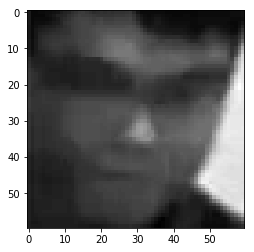

In [2]:
size = (60, 60) #width, height

image = array(Image.open('../face_data/1_0.png').convert('L').resize(size, Image.BILINEAR))
plt.imshow(image, cmap='gray')
plt.show()

In [3]:
from skimage.filters import gabor_kernel
from scipy import ndimage as ndi

def prepare_gabor_filter_bank(n_orientations, n_frequencies):
    # prepare filter bank kernels
    kernels = []
    for theta in range(n_orientations):
        theta = theta / n_orientations * np.pi
        kmax = np.pi / 2.
        for frequency in np.arange(kmax / n_frequencies, kmax + 0.1, kmax / n_frequencies): # add 0.01 because 1.6 included
            kernel = np.real(gabor_kernel(frequency, theta=theta))
            kernels.append(kernel)
                
    return kernels

def apply_kernels_to_image(image, kernels):
    convolved_result_list = []
    for k, kernel in enumerate(kernels):
        convolved_result = ndi.convolve(image, kernel, mode='wrap')
        convolved_result_list.append(convolved_result)
    return convolved_result_list

In [4]:
kernels = prepare_gabor_filter_bank(5, 8)

In [5]:
print(len(kernels))

40


In [6]:
print(image.shape)

(60, 60)


In [7]:
convolved_result_list = apply_kernels_to_image(image, kernels)

In [8]:
print(len(convolved_result_list))

40


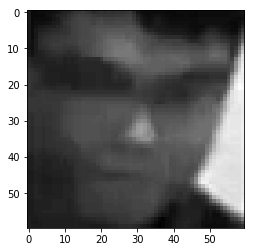

In [9]:
plt.imshow(convolved_result_list[6], cmap='gray')

# Apply LBP

In [10]:
from skimage.feature import local_binary_pattern

In [11]:
def apply_lbp_operator_to_convolutional_list(conv_list, method, radius, n_points):
    lbp_result_list = []
    for conv in conv_list:
        lbp_result = local_binary_pattern(conv, n_points, radius, method)
        lbp_result_list.append(lbp_result)
    return lbp_result_list

In [12]:
lbp_result_list = apply_lbp_operator_to_convolutional_list(convolved_result_list, 'uniform', 1, 8)

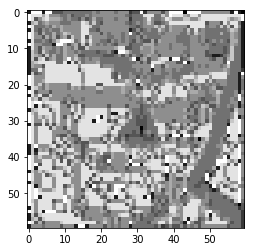

In [13]:
plt.imshow(lbp_result_list[3], cmap='gray')

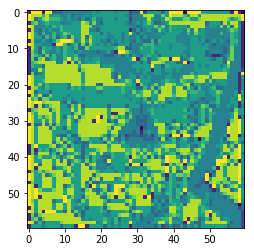

In [14]:
plt.imshow(lbp_result_list[3])

In [15]:
lbp_result_list[3][1]

array([9., 8., 8., 8., 6., 8., 5., 5., 5., 4., 4., 5., 3., 4., 4., 4., 5.,
       4., 5., 5., 5., 5., 5., 5., 5., 5., 5., 4., 3., 4., 4., 4., 8., 8.,
       8., 4., 4., 7., 5., 9., 8., 8., 8., 6., 5., 8., 8., 5., 8., 8., 8.,
       8., 8., 8., 8., 8., 8., 8., 8., 9.])

# Partition Sub-region

In [16]:
def partition_lbp_list(lbp_list, local_height, local_width):
    partition_result_list = []
    width, height = lbp_list[0].shape
    for lbp in lbp_list:
        for iterator_height in range(height // local_height):
            for iterator_width in range(width // local_width):
                x_start = iterator_width * local_width
                x_end = (iterator_width + 1) * local_width
                y_start = iterator_height * local_height
                y_end = (iterator_height + 1) * local_height
                
                partition_result = lbp[y_start: y_end, x_start : x_end]
                partition_result_list.append(partition_result)
    return partition_result_list

In [17]:
partition_list = partition_lbp_list(lbp_result_list, 15, 15)
print(len(partition_list))

640


In [18]:
partition_list[0]

array([[8., 1., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8.],
       [8., 9., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8.],
       [8., 9., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8.],
       [8., 9., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8.],
       [8., 9., 9., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8.],
       [8., 5., 9., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8.],
       [8., 4., 9., 8., 1., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8.],
       [8., 4., 1., 8., 9., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8.],
       [8., 4., 9., 6., 9., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8.],
       [8., 5., 9., 8., 5., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8.],
       [8., 4., 9., 8., 5., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8.],
       [1., 9., 1., 8., 5., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8.],
       [1., 8., 9., 8., 1., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8.],
       [9., 8., 1., 6., 9., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8.],
       [1., 8., 9., 8., 5., 8., 8.

# Matching

In [19]:
import math

def bhattacharyya_distance(hist1, hist2):
#     print(hist1, 'haha')
#     print(hist2, 'hehe')
    # calculate mean of hist1
    h1_ = np.mean(hist1);

    # calculate mean of hist2
    h2_ = np.mean(hist2);

    # calculate score
    score = 0;
    if (hist1.all() == hist2.all()):
        return 0
    else:
        for i in range(len(hist1)):
            score += math.sqrt( hist1[i] * hist2[i] );
#         print(score, 'hahae')
#         print(1 - (1 / math.sqrt(h1_*h2_*len(hist1)*len(hist1))) * score)
#         print(( 1 / math.sqrt(h1_*h2_*len(hist1)*len(hist1)) ) * score )
        score = math.sqrt( 1 - ( 1 / math.sqrt(h1_*h2_*len(hist1)*len(hist1)) ) * score );
        return score

def match_two_image(image1_hist, image2_hist):
    aggregated_score = 0
    
    for idx_lbp, hist_lbp in enumerate(image1_hist):
        for idx_partition, hist_partition in enumerate(hist_lbp):
            aggregated_score += bhattacharyya_distance(hist_partition, image2_hist[idx_lbp][idx_partition])
    return aggregated_score

In [20]:
def generate_lgbphs_from_image(image_filename):
    size = (100, 100) #width, height

    image = array(Image.open(image_filename).convert('L').resize(size, Image.BILINEAR))
#     plt.imshow(image, cmap='gray')
#     plt.show()
    
    kernels = prepare_gabor_filter_bank(5, 8)
    convolved_result_list = apply_kernels_to_image(image, kernels)
    
    lbp_result_list = apply_lbp_operator_to_convolutional_list(convolved_result_list, 'uniform', 1, 8)
    
    partition_list = partition_lbp_list(lbp_result_list, 20, 20)
    
    return partition_list

In [21]:
lgbphs_feature_image1 = generate_lgbphs_from_image('../face_data/1_0.png')

In [22]:
lgbphs_feature_image2 = generate_lgbphs_from_image('../face_data/1_7.png')

In [23]:
match_two_image(lgbphs_feature_image1, lgbphs_feature_image2)

316.04640662127576

# Compare PCA vs LGBPHS

In [24]:
import os
import scipy

In [25]:
img_path_list = os.listdir('../face_data')
img_path_list = [os.path.join('../face_data', img_path) for img_path in img_path_list]

In [26]:
target = []
for img_path in img_path_list:
    if ('/1_' in img_path):
        target.append(1)
    elif ('/2_' in img_path):
        target.append(2)
    elif ('/7_' in img_path):
        target.append(3)
    elif ('/12_' in img_path):
        target.append(3)
    elif ('/17_' in img_path):
        target.append(4)

In [27]:
from sklearn.model_selection import train_test_split

In [28]:
X_train_filename, X_test_filename, y_train_filename, y_test_filename = train_test_split(
    img_path_list, target, test_size=0.2, random_state=0
)

In [29]:
def read_batch_image(img_path_list, resized_dimension=(100,100)):
    image_data_list = []
    for img_path in img_path_list:
        img = Image.open(img_path).convert('L')
        img = array(img, dtype=float)/255.0
        img = scipy.misc.imresize(img, resized_dimension, interp='bilinear', mode=None)
        image_data_list.append(img)
    return image_data_list

def flatten_batch_image(image_data_list):
    flattened_image_list = []
    for i in range(len(image_data_list)):
        flattened_image = image_data_list[i].flatten()
        flattened_image_list.append(flattened_image)
    return flattened_image_list

## PCA

In [30]:
X_train_image_data = np.matrix(flatten_batch_image(read_batch_image(X_train_filename)))
X_test_image_data = np.matrix(flatten_batch_image(read_batch_image(X_test_filename)))

/home/agusgun/anaconda3/envs/basic/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  


In [31]:
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score

In [32]:
pca_component = 15
pca = PCA(pca_component, whiten=True).fit(X_train_image_data)

In [33]:
X_train_pca = pca.transform(X_train_image_data)
X_test_pca = pca.transform(X_test_image_data)

In [34]:
knn_classifier = KNeighborsClassifier(n_neighbors = 3)
knn_classifier.fit(X_train_pca, y_train_filename)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=3, p=2,
           weights='uniform')

In [35]:
predicted = knn_classifier.predict(X_test_pca)

print(accuracy_score(predicted, y_test_filename))
print(f1_score(predicted, y_test_filename, average='weighted'))

0.9298245614035088
0.9296410962045637


## LGBPHS

In [36]:
X_train_feature = []
for image_filename in X_train_filename:
    X_train_feature.append(generate_lgbphs_from_image(image_filename))
    
X_test_feature = []
for image_filename in X_test_filename:
    X_test_feature.append(generate_lgbphs_from_image(image_filename))

In [37]:
def predict_lgbphs(image_test_feature, image_train_feature_list, train_label_list):
    min_score = np.inf
    predict_result = 0
    for idx, image_feature in enumerate(image_train_feature_list):
        score = match_two_image(image_feature, image_test_feature)
        if score < min_score:
            predict_result = train_label_list[idx]
            min_score = score
            
    return predict_result

In [38]:
%%time

predict_lgbphs(X_test_feature[0], X_train_feature, y_train_filename)

CPU times: user 1min 35s, sys: 0 ns, total: 1min 35s
Wall time: 1min 35s


4

In [39]:
y_test_filename[0]

4

# Final Conclusion: LGBPHS too slow to be used in the system

Paper Source: Cho et al